In [78]:
import matplotlib.pyplot as plt
import pandas as pd
import shared_utils
from scipy.stats import zscore
import seaborn as sns
import numpy as np

# set_option to increase max rows displayed to 200, to see entire df in 1 go/
pd.set_option("display.max_rows", 200)

## Read in cost per bus data

In [ ]:
# FTA Grant Award Press Release Data
fta = pd.read_csv('gs://calitp-analytics-data/data-analyses/bus_procurement_cost/fta_cost_per_bus.csv')

In [ ]:
# TIRCP Project Tracking Data 
tircp = pd.read_csv('gs://calitp-analytics-data/data-analyses/bus_procurement_cost/tircp_project_cost_per_bus.csv')

## Dataset cleaning

In [ ]:
# peaking into each dataset
data=[fta, tircp]

for x in data:
    display(x.shape,
           x.columns,
           x.dtypes,
           x.head())

In [ ]:
#look to drop column from each df
data=[fta, tircp]

for x in data:
    x.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
display(fta.columns,
tircp.columns)

### reorder columns

In [ ]:
new_order =['grant_recipient',
              'tircp_award_amount_($)',
              'bus_count',
              'cost_per_bus']
tircp = tircp[new_order]

### rename columns to match eachother

In [ ]:
new_col =['project_sponsor', 'funding', 'bus_count', 'cost_per_bus']

tircp.columns=new_col

In [ ]:
display(list(fta.columns),
list(tircp.columns))

In [ ]:
# add new col to identify source
fta['source']='fta'
tircp['source']='tircp_project_tracking'

In [ ]:
display(fta.head(),tircp.head())

### Concat both dataframes

In [ ]:
concat = pd.concat([fta,tircp], axis=0).reset_index()

In [ ]:
concat = concat.drop('index', axis=1)

In [ ]:
concat

In [ ]:
list(concat.project_sponsor.sort_values().unique())

## Export concat data

In [ ]:
concat.to_csv('gs://calitp-analytics-data/data-analyses/bus_procurement_cost/fta_tircp_concat.csv')

## Read in concat data (TIRCP and FTA data)

In [ ]:
concat = pd.read_csv('gs://calitp-analytics-data/data-analyses/bus_procurement_cost/fta_tircp_concat.csv')

In [ ]:
display(concat.shape,
        concat.dtypes,
        concat.head(),
       )
        

In [ ]:
# add new column for z-score
concat['zscore_' + 'cost_per_bus'] = zscore(concat['cost_per_bus'])

In [ ]:
concat.shape

In [ ]:
# remove outliers
#filter df for zscores =>-3<=3
filtered = concat[(concat['zscore_cost_per_bus'] >= -3) & (concat['zscore_cost_per_bus'] <=3)]

In [ ]:
# 2 rows were dropped
filtered.shape

In [ ]:
filtered.zscore_cost_per_bus.max()

In [ ]:
filtered.sort_values(by='cost_per_bus', ascending=False).head()

## Stats Analysis

In [ ]:
mean = np.mean(filtered['cost_per_bus'])
std_dev = np.std(filtered['cost_per_bus'])

#zscore
mean2 = np.mean(filtered['zscore_cost_per_bus'])
std_dev2 = np.std(filtered['zscore_cost_per_bus'])


In [ ]:
mean2 + (std_dev2*3)

## Summary

In [ ]:
concat.head()

In [ ]:
concat.sort_values(by='cost_per_bus',ascending=True).head()

In [79]:
# Variables
total_unique_projects = len(concat)
total_bus_count = sum(concat.bus_count)
total_funding = sum(concat.funding)
min_bus_cost = concat.cost_per_bus.min()
max_bus_cost = concat.cost_per_bus.max()
max_bus_count = concat.bus_count.max()

mean = np.mean(filtered['cost_per_bus'])
std_dev = np.std(filtered['cost_per_bus'])

agency_with_most_bus = concat.loc[concat['bus_count'].idxmax(), 'project_sponsor']
#how many buses do they have? already answered
agency_with_highest_funds = concat.loc[concat['funding'].idxmax(), 'project_sponsor']
#what is the highest amount? already answered
agency_max_cpb = concat.loc[concat['cost_per_bus'].idxmax(), 'project_sponsor']
agency_min_cpb = concat.loc[concat['cost_per_bus'].idxmin(), 'project_sponsor']

In [80]:
summary = f'''
As of today, data was scraped from mutltiple sources:
    1. FTA Bus and Low- and No-Emission Grant Awards press release (federaly funded, nationwide data)
    2. TIRCP project data (state-funded, California only)
    
Data from DGS usage reports, Georgia and Washington contracts to be analyzed next.

Note, some projects included additional compoments besides bus purchases (chargers, transit facilities, parts, training) which may cause project costs to increase dramaticly, whereas other projects specified only bus purcahses, and some did not include and bus purchases at all.

Datasets was filtered to only include data that specificed the number of buses to purchase. The compiled data was aggregated by agencies and a 'cost per_bus' metric was calculated by dividing the total funding the agency received by the total number of buses they specify.

In total:
    - {total_unique_projects} projects with bus purchases were analyzed.
    - ${total_funding:,.2f} was awarded to agencies for projects including bus purchases.
    - {total_bus_count} total buses are to be purchased.
    - The highest cost per bus for an agency was ${max_bus_cost:,.2f}, belonging too {agency_max_cpb} 
    - The lowest cost per bus for an agency was ${min_bus_cost:,.2f}, belonging too {agency_min_cpb}
    

The agency with the most buses specified was {agency_with_most_bus} with {max_bus_count} buses.

After removing outliers, the following was discovered:
    - the mean cost per bus is ${mean:,.2f}.
    - the standard deviation is ${std_dev:,.2f}. 

Below are charts that summarize the data.
'''

In [87]:
concat.head()

,Unnamed: 0,project_sponsor,funding,bus_count,cost_per_bus,source,zscore_cost_per_bus
0,0,AUTORIDAD METROPOLITANA DE AUTOBUSES (PRMBA),10000000,8.0,1250000,fta,0.175536
1,1,Alameda-Contra Costa Transit District,25513684,25.0,1020547,fta,-0.025151
2,2,Berkshire Regional Transit Authority,2212747,2.0,1106373,fta,0.049915
3,3,Brazos Transit District,9650646,11.0,877331,fta,-0.150412
4,4,Cape Fear Public Transportation Authority,2860250,5.0,572050,fta,-0.417420


In [81]:
print(summary)


As of today, data was scraped from mutltiple sources:
    1. FTA Bus and Low- and No-Emission Grant Awards press release (federaly funded, nationwide data)
    2. TIRCP project data (state-funded, California only)
    
Data from DGS usage reports, Georgia and Washington contracts to be analyzed next.

Note, some projects included additional compoments besides bus purchases (chargers, transit facilities, parts, training) which may cause project costs to increase dramaticly, whereas other projects specified only bus purcahses, and some did not include and bus purchases at all.

Datasets was filtered to only include data that specificed the number of buses to purchase. The compiled data was aggregated by agencies and a 'cost per_bus' metric was calculated by dividing the total funding the agency received by the total number of buses they specify.

In total:
    - 125 projects with bus purchases were analyzed.
    - $2,041,714,791.00 was awarded to agencies for projects including bus purc

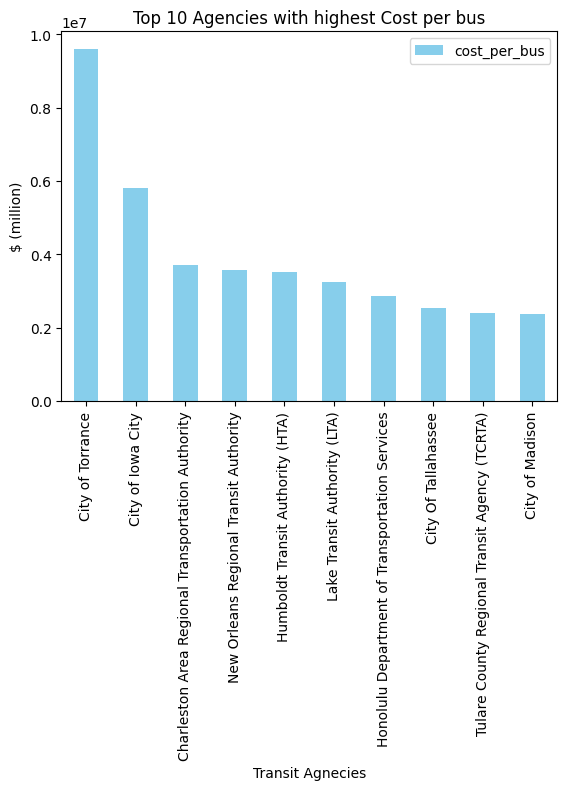

In [82]:
#bar chart of highest cost per bus
concat.sort_values(by='cost_per_bus', ascending=False).head(10).plot(x='project_sponsor', y='cost_per_bus', kind='bar', color='skyblue')
plt.title('Top 10 Agencies with highest Cost per bus')
plt.xlabel('Transit Agnecies')
plt.ylabel('$ (million)')
plt.show()

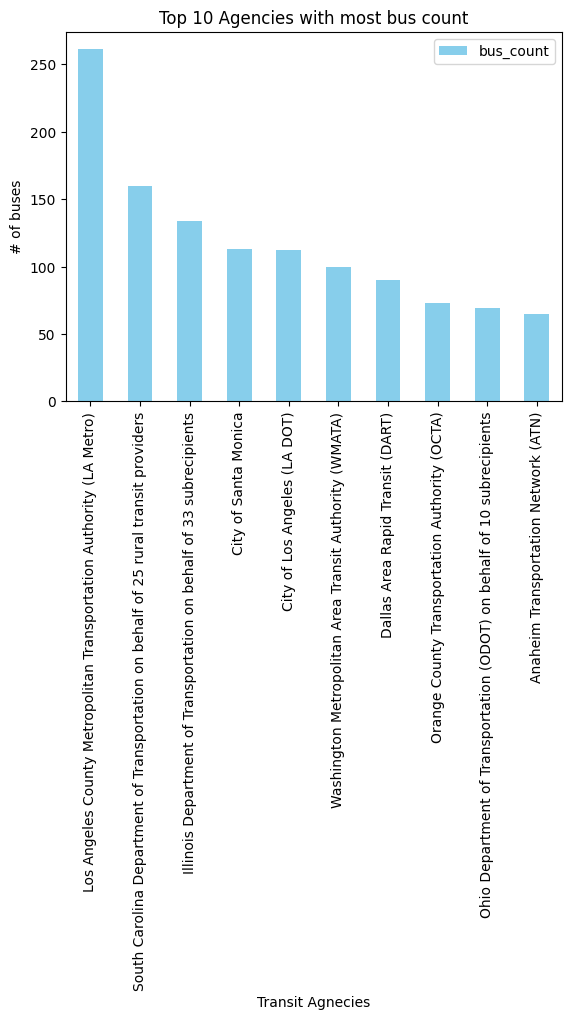

In [83]:
#bar chart of highest bus count
concat.sort_values(by='bus_count', ascending=False).head(10).plot(x='project_sponsor', y='bus_count', kind='bar', color='skyblue')
plt.title('Top 10 Agencies with most bus count')
plt.xlabel('Transit Agnecies')
plt.ylabel('# of buses')
plt.show()

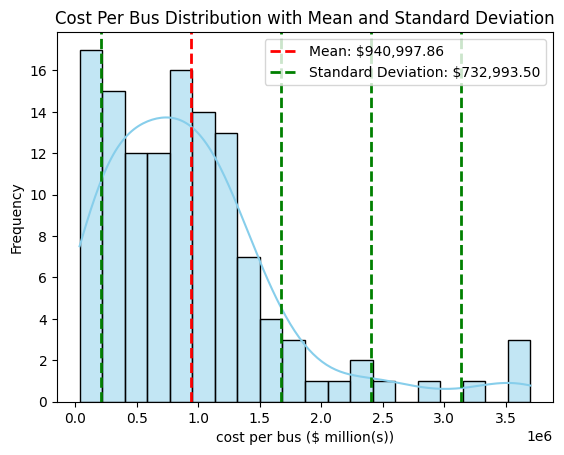

In [84]:
# distribution curve of cost per bus. no outliers
sns.histplot(filtered['cost_per_bus'], kde=True, color='skyblue', bins=20)
plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: ${mean:,.2f}')
plt.axvline(mean + std_dev, color='green', linestyle='dashed', linewidth=2, label=f'Standard Deviation: ${std_dev:,.2f}')
plt.axvline(mean - std_dev, color='green', linestyle='dashed', linewidth=2)
plt.axvline(mean + std_dev*2, color='green', linestyle='dashed', linewidth=2)
plt.axvline(mean + std_dev*3, color='green', linestyle='dashed', linewidth=2)

plt.title('Cost Per Bus Distribution with Mean and Standard Deviation')
plt.xlabel('cost per bus ($ million(s))')
plt.ylabel('Frequency')
plt.legend()
plt.show()

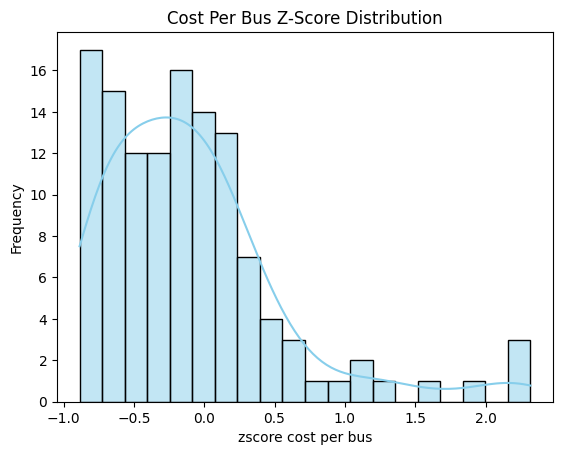

In [85]:
#distribution curve of zscore
sns.histplot(filtered['zscore_cost_per_bus'], kde=True, color='skyblue', bins=20)
#plt.axvline(mean2, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean2:.2f}')
#plt.axvline(mean2 + std_dev2, color='green', linestyle='dashed', linewidth=2, label=f'Standard Deviation: {std_dev2:,.2f}')
#plt.axvline(mean2 - std_dev2, color='green', linestyle='dashed', linewidth=2)
#plt.axvline(mean2 + (std_dev2*2), color='green', linestyle='dashed', linewidth=2)
#plt.axvline(mean2 + (std_dev2*3), color='green', linestyle='dashed', linewidth=2)
#plt.axvline(mean2 - (std_dev2*2), color='green', linestyle='dashed', linewidth=2)
#plt.axvline(mean2 - (std_dev2*3), color='green', linestyle='dashed', linewidth=2)

plt.title('Cost Per Bus Z-Score Distribution')
plt.xlabel('zscore cost per bus')
plt.ylabel('Frequency')
plt.show()